In [1]:
import numpy as np
import matplotlib.pyplot as py
import getdist as gs
import os
from getdist import plots, loadMCSamples
from pathlib import Path

First I will define the dynamics

In [2]:
def vect(x, y, m):
    xdot = y
    ydot = -((3)**0.5)*y*(0.5*(y**2) + 0.5*m*(x**2))**0.5 - x*m
    return xdot, ydot

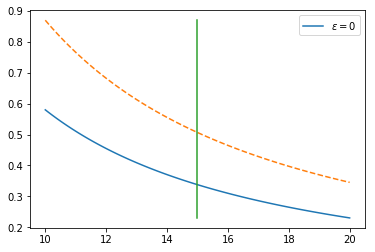

In [6]:
h60 = 2.5
k = 4/3
linechoice = 15

phi60 = np.linspace(10, 20, 101)
Vzero = [(h60**2)*2/(phi**k) for phi in phi60]
Vzero2 = [(h60**2)*3/(phi**k) for phi in phi60]

py.plot(phi60, Vzero, label = '$ε = 0$')
py.plot(phi60, Vzero2, '--')
py.plot(np.linspace(linechoice, linechoice, 11), np.linspace(Vzero[-1], Vzero2[0], 11))
py.legend()

The streamplot function doesn't much appreciate small numbers, so we scale $H_0 \rightarrow H_0 \times 10^5 = \tilde{H_0}$, $V_0 \rightarrow V_0 \times 10^{10} = \tilde{V_0}$

In [4]:
def traj(xstart, ystart, m, dt=0.001, no_iter = 1000):
    T = int(no_iter/dt)
    t = np.zeros(no_iter + 1)
    x = np.zeros(no_iter + 1)
    y = np.zeros(no_iter + 1)
    x[0]  =xstart
    y[0] = ystart
    n=0
    while n<no_iter:
        X1, Y1 = vect(x[n], y[n], m)
        X2, Y2 = vect(x[n] + 0.5*dt*X1, y[n] + 0.5*dt*Y1, m)
        X3, Y3 = vect(x[n] + 0.5*dt*X2, y[n] + 0.5*dt*Y2, m)
        X4, Y4 = vect(x[n] + dt*X3, y[n] + dt*Y3, m)
        gradx, grady = (X1 + 2*X2 + 2*X3 + X4)/6, (Y1 + 2*Y2 + 2*Y3 + Y4)/6
        x[n+1], y[n+1] = x[n] + gradx*dt, y[n] + grady*dt
        t[n+1] = t[n] + dt
        n += 1
    return t, x, y
    

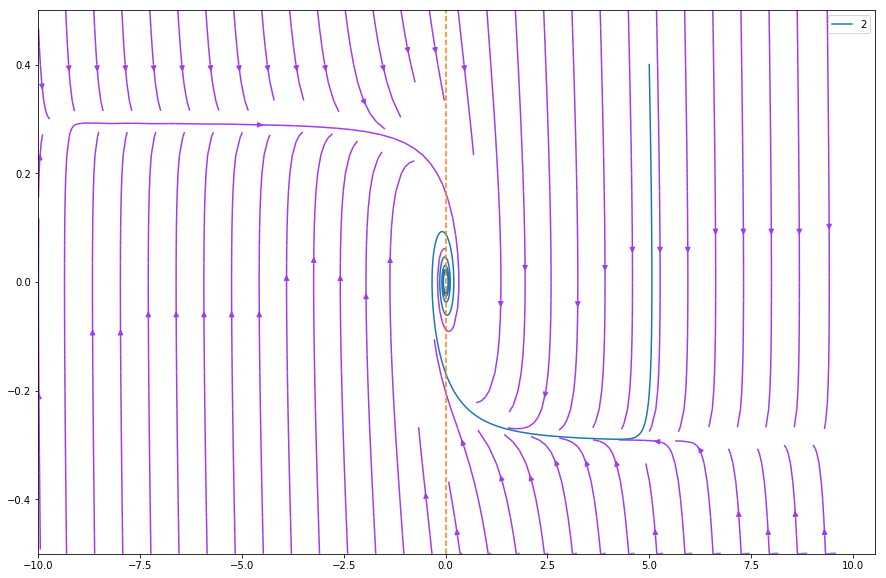

In [5]:
M = 0.13
xbound = 10
ybound = 0.5
nx, ny = 1024, 1024
x = np.linspace(-1*xbound, xbound, nx)
y = np.linspace(-ybound, ybound, ny)
X, Y = np.meshgrid(x, y)

py.figure(figsize=(15, 10)) 
py.streamplot(X, Y, vect(X, Y, M)[0], vect(X, Y, M)[1], density=1.0, linewidth=None, color='#A23BEC')
#_, trajx, trajy = traj(-xbound, ybound, M, no_iter = 100000)
#py.plot(trajx, trajy, label = "1")
_, sackx, sacky = traj(0.5*xbound, 0.8*ybound, M, no_iter = 100000)
py.plot(sackx, sacky, label = "2")
#_, shitx, shity = traj(-0.5*xbound, ybound, M, no_iter = 100000)
#py.plot(shitx, shity, label = "3")
py.plot(np.zeros(101), np.linspace(-ybound, ybound, 101), '--')
py.legend()

In [ ]:
nx, ny = 32, 32
x = np.linspace(-12, 12, nx)
y = np.linspace(-1.5, 1.5, ny)
X, Y = np.meshgrid(x, y)

py.figure(figsize = (10, 8))
py.quiver(X, Y, vect(X, Y, M)[0], vect(X, Y, M)[1])

Let's add the $H$ trajectory data to the plot

In [6]:
grad_calc = lambda H, V0, phi, k: (1.5*(H**2) - 0.5*V0*(phi**k))**0.5
epsilon_calc = lambda  H, V0, phi, k: 2*(1.5*(H**2) - 0.5*V0*(phi**k))/(H**2)

In [7]:
def trajectory(V_0, k, phi_0, dphi0 = 0.0001, boundmultiplier = 100, H0 = 2.5, suppress = False):
    if not (3*(H0**2)/((phi_0)**k) > V_0 > 2*(H0**2)/((phi_0)**k) or suppress):
        raise Exception("wrong parameter choice")
    T =  int(phi_0/dphi0)
    phi = np.zeros(boundmultiplier*T+1)  #adapting mesh for phi
    H = np.zeros(boundmultiplier*T+1)
    phi[0] = phi_0
    H[0]  = H0
    epsilon = epsilon_calc(H[0], V_0, phi[0], k)
    n = 0
    dphi = dphi0
    #SPACE
    while (epsilon < 1) and (n < boundmultiplier*T):
        K1 = grad_calc(H[n], V_0, phi[n], k)
        K2 = grad_calc(H[n] - 0.5*dphi*K1, V_0, phi[n] - 0.5*dphi, k)
        K3 = grad_calc(H[n] - 0.5*dphi*K2, V_0, phi[n] - 0.5*dphi, k)
        K4 = grad_calc(H[n] - dphi*K3, V_0, phi[n] - dphi, k)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n+1] = H[n] - dphi*grad
        phi[n+1] = phi[n] - dphi
        epsilon = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        dphi = min(0.9*(H[n+1] - ((V_0*(phi[n+1])**k)*(1/3))**0.5)/(grad_calc(H[n+1], V_0, phi[n+1], k)), dphi0)
        n += 1
    return phi[0:n+1], H[0:n+1], n, epsilon

def tot_traj(Nstart, V_0, k, phi_0 = 10, dphi0 = 0.0001, boundmultiplier = 100, H0 = 2.5, suppress = False, epsilonstop = False):
    T = int(phi_0/dphi0)
    phiswap, Jswap, n0, epsilon = trajectory(V_0, k, phi_0, dphi0, boundmultiplier, H0, suppress)
    phi1, J1 = phiswap[::-1], Jswap[::-1]
    N = 0
    phi = np.zeros(boundmultiplier*T + 1)
    H = np.zeros(boundmultiplier*T + 1)
    ε = np.zeros(boundmultiplier*T + 1)
    phi[:n0 + 1] = phi1
    H[:n0 + 1] = J1
    ε[0] = epsilon
    n = 0
    while (N < Nstart) and (n < n0):
        dphi = phi[n+1] - phi[n]
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        J1 = (2 / ε[n])**0.5
        J2 = (2 / ε[n+1])**0.5
        N += dphi*(J1 + J2)/4
        n += 1
    #Space
    while (N < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
        dphi = min(0.5*(H[n] - ((V_0*(phi[n])**k)*(1/3))**0.5)/(grad_calc(H[n], V_0, phi[n], k)), dphi0)
        K1 = grad_calc(H[n], V_0, phi[n], k)
        K2 = grad_calc(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, k)
        K3 = grad_calc(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, k)
        K4 = grad_calc(H[n] + dphi*K3, V_0, phi[n] + dphi, k)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n+1] = H[n] + dphi*grad
        phi[n+1] = phi[n] + dphi
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        #SPACE
        J1 = (2 / ε[n])**0.5
        J2 = (2 / ε[n+1])**0.5
        N += dphi*(J1 + J2)/4
        n += 1
    return phi[:n+1], H[:n+1], n, ε[:n+1], N

n = 141271
N = 54.15603761326319
Full trajectory not available via this method - ε > 1 at n = 141271


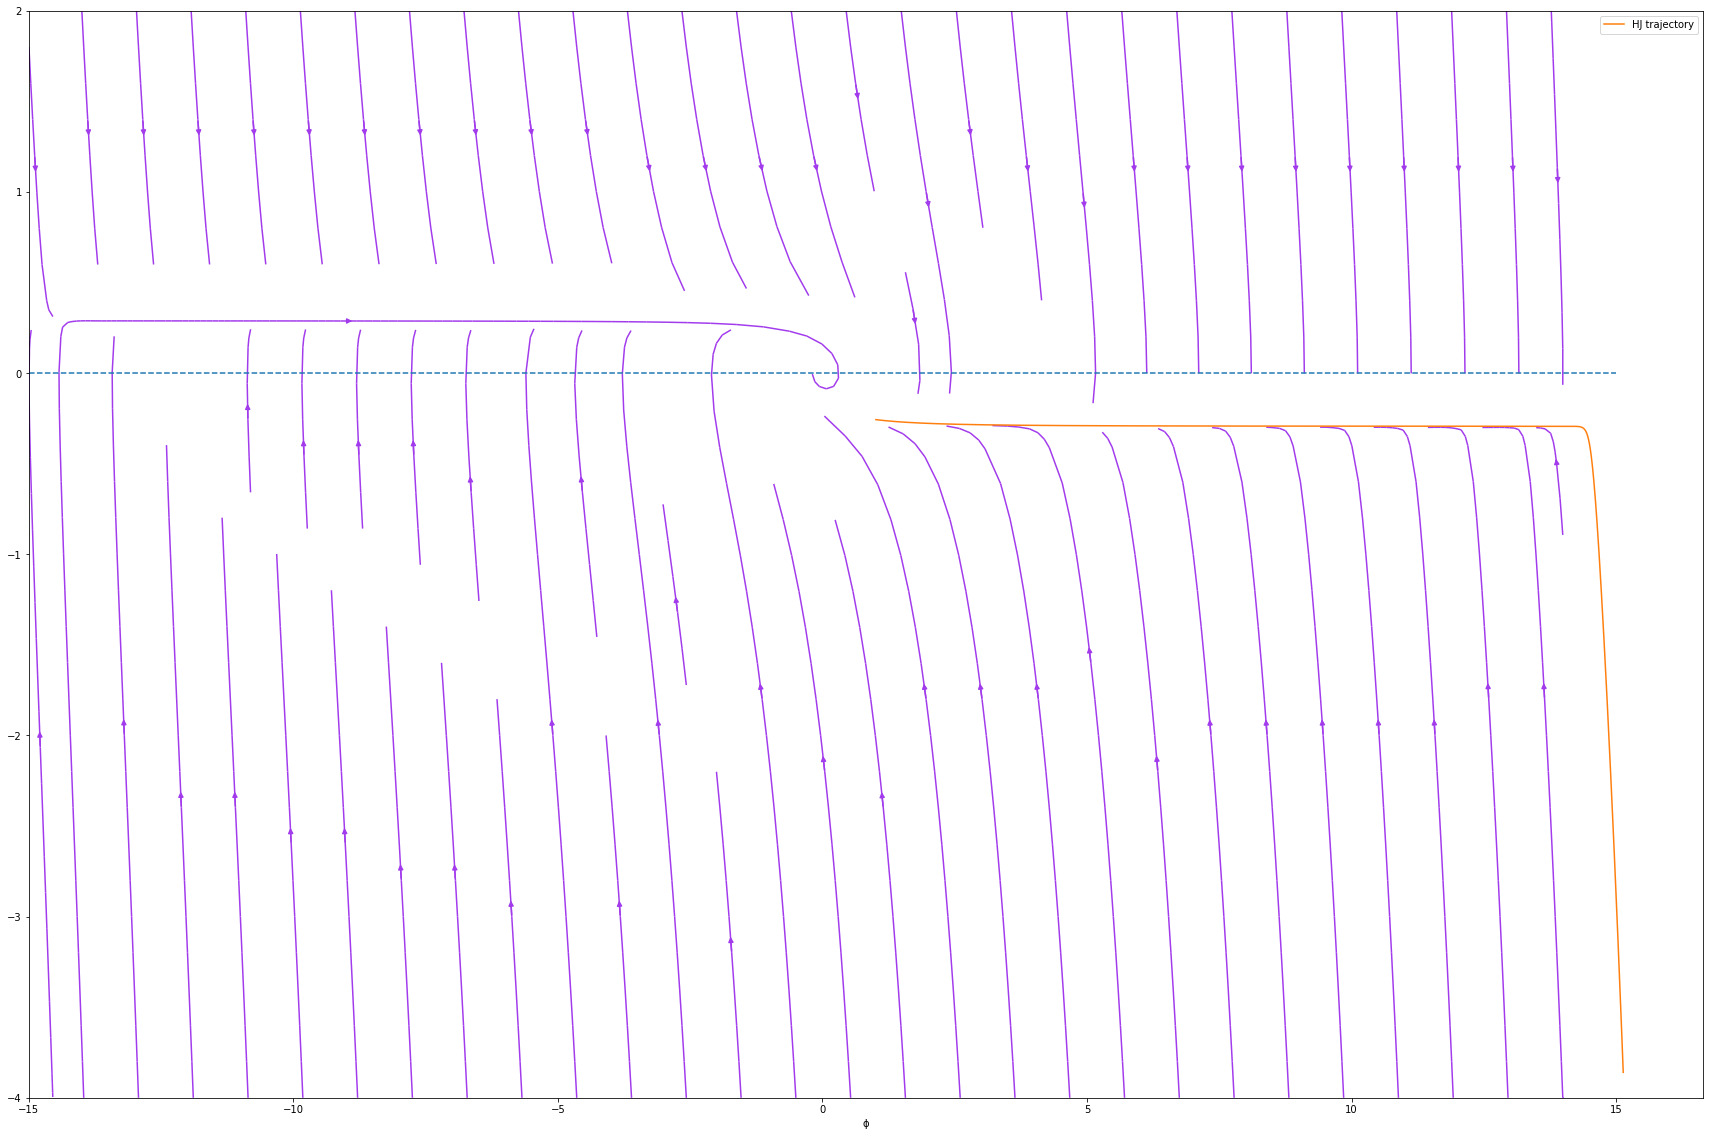

In [9]:
kchoice = 2
V0choice = 0.065

M = 2*V0choice
xbound = 15
ybound = 4
nx, ny = 1024, 1024
x = np.linspace(-1*xbound, xbound, nx)
y = np.linspace(-ybound, 0.5*ybound, ny)
X, Y = np.meshgrid(x, y)

plane = py.figure(figsize=(30, 20)) 
py.streamplot(X, Y, vect(X, Y, M)[0], vect(X, Y, M)[1], density=1.0, linewidth=None, color='#A23BEC')
py.plot(np.linspace(-xbound, xbound, 101), np.zeros(101), '--')

phi, H, n, epsilon, N = tot_traj(60, V0choice, kchoice, phi_0 = 15, suppress = False, epsilonstop = True)
Vset = [V0choice*ϕ**kchoice for ϕ in phi]
phidot = [-(6*((H[i])**2) - 2*(Vset[i]))**0.5 for i in range(len(phi))]
py.plot(phi, phidot, label='HJ trajectory')
#py.plot(phi, epsilon, label='ε')
py.xlabel('ϕ')
py.legend()
print("n =", n, end = '\n')
print("N =", N, end = '\n')
for i, el in enumerate(epsilon):
    if el >1 and i>0:
        print("Full trajectory not available via this method - ε > 1 at n = %s"%i)
        break

I'm curious as to what will happen with a $H' < 0$ branch choice

In [48]:
def trajectory_minus(V_0, k, phi_0, dphi0 = 0.0001, boundmultiplier = 100, H0 = 2.5, suppress = False):
    if not (3*(H0**2)/((phi_0)**k) > V_0 > 2*(H0**2)/((phi_0)**k) or suppress):
        raise Exception("wrong parameter choice")
    T =  int(phi_0/dphi0)
    phi = np.zeros(boundmultiplier*T+1)  #adapting mesh for phi
    H = np.zeros(boundmultiplier*T+1)
    phi[0] = phi_0
    H[0]  = H0
    epsilon = epsilon_calc(H[0], V_0, phi[0], k)
    n = 0
    dphi = dphi0
    #SPACE
    while (epsilon < 1) and (n < boundmultiplier*T):
        K1 = grad_calc(H[n], V_0, phi[n], k)
        K2 = grad_calc(H[n] - 0.5*dphi*K1, V_0, phi[n] - 0.5*dphi, k)
        K3 = grad_calc(H[n] - 0.5*dphi*K2, V_0, phi[n] - 0.5*dphi, k)
        K4 = grad_calc(H[n] - dphi*K3, V_0, phi[n] - dphi, k)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n+1] = H[n] + dphi*grad
        phi[n+1] = phi[n] - dphi
        epsilon = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        dphi = min(0.9*(H[n+1] - ((V_0*(phi[n+1])**k)*(1/3))**0.5)/(grad_calc(H[n+1], V_0, phi[n+1], k)), dphi0)
        n += 1
    return phi[0:n+1], H[0:n+1], n, epsilon

def tot_traj_minus(Nstart, V_0, k, phi_0 = 10, dphi0 = 0.0001, boundmultiplier = 100, H0 = 2.5, suppress = False, epsilonstop = False):
    T = int(phi_0/dphi0)
    phiswap, Jswap, n0, epsilon = trajectory_minus(V_0, k, phi_0, dphi0, boundmultiplier, H0, suppress)
    phi1, J1 = phiswap[::-1], Jswap[::-1]
    N = 0
    phi = np.zeros(boundmultiplier*T + 1)
    H = np.zeros(boundmultiplier*T + 1)
    ε = np.zeros(boundmultiplier*T + 1)
    phi[:n0 + 1] = phi1
    H[:n0 + 1] = J1
    ε[0] = epsilon
    n = 0
    while (N < Nstart) and (n < n0):
        dphi = phi[n+1] - phi[n]
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        J1 = (2 / ε[n])**0.5
        J2 = (2 / ε[n+1])**0.5
        N += dphi*(J1 + J2)/4
        n += 1
    #Space
    while (N < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
        dphi = min(0.5*(H[n] - ((V_0*(phi[n])**k)*(1/3))**0.5)/(grad_calc(H[n], V_0, phi[n], k)), dphi0)
        K1 = grad_calc(H[n], V_0, phi[n], k)
        K2 = grad_calc(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, k)
        K3 = grad_calc(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, k)
        K4 = grad_calc(H[n] + dphi*K3, V_0, phi[n] + dphi, k)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n+1] = H[n] - dphi*grad
        phi[n+1] = phi[n] + dphi
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        #SPACE
        J1 = (2 / ε[n])**0.5
        J2 = (2 / ε[n+1])**0.5
        N += dphi*(J1 + J2)/4
        n += 1
    return phi[:n+1], H[:n+1], n, ε[:n+1], N

C:\Users\Jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


n = 4163
N = nan


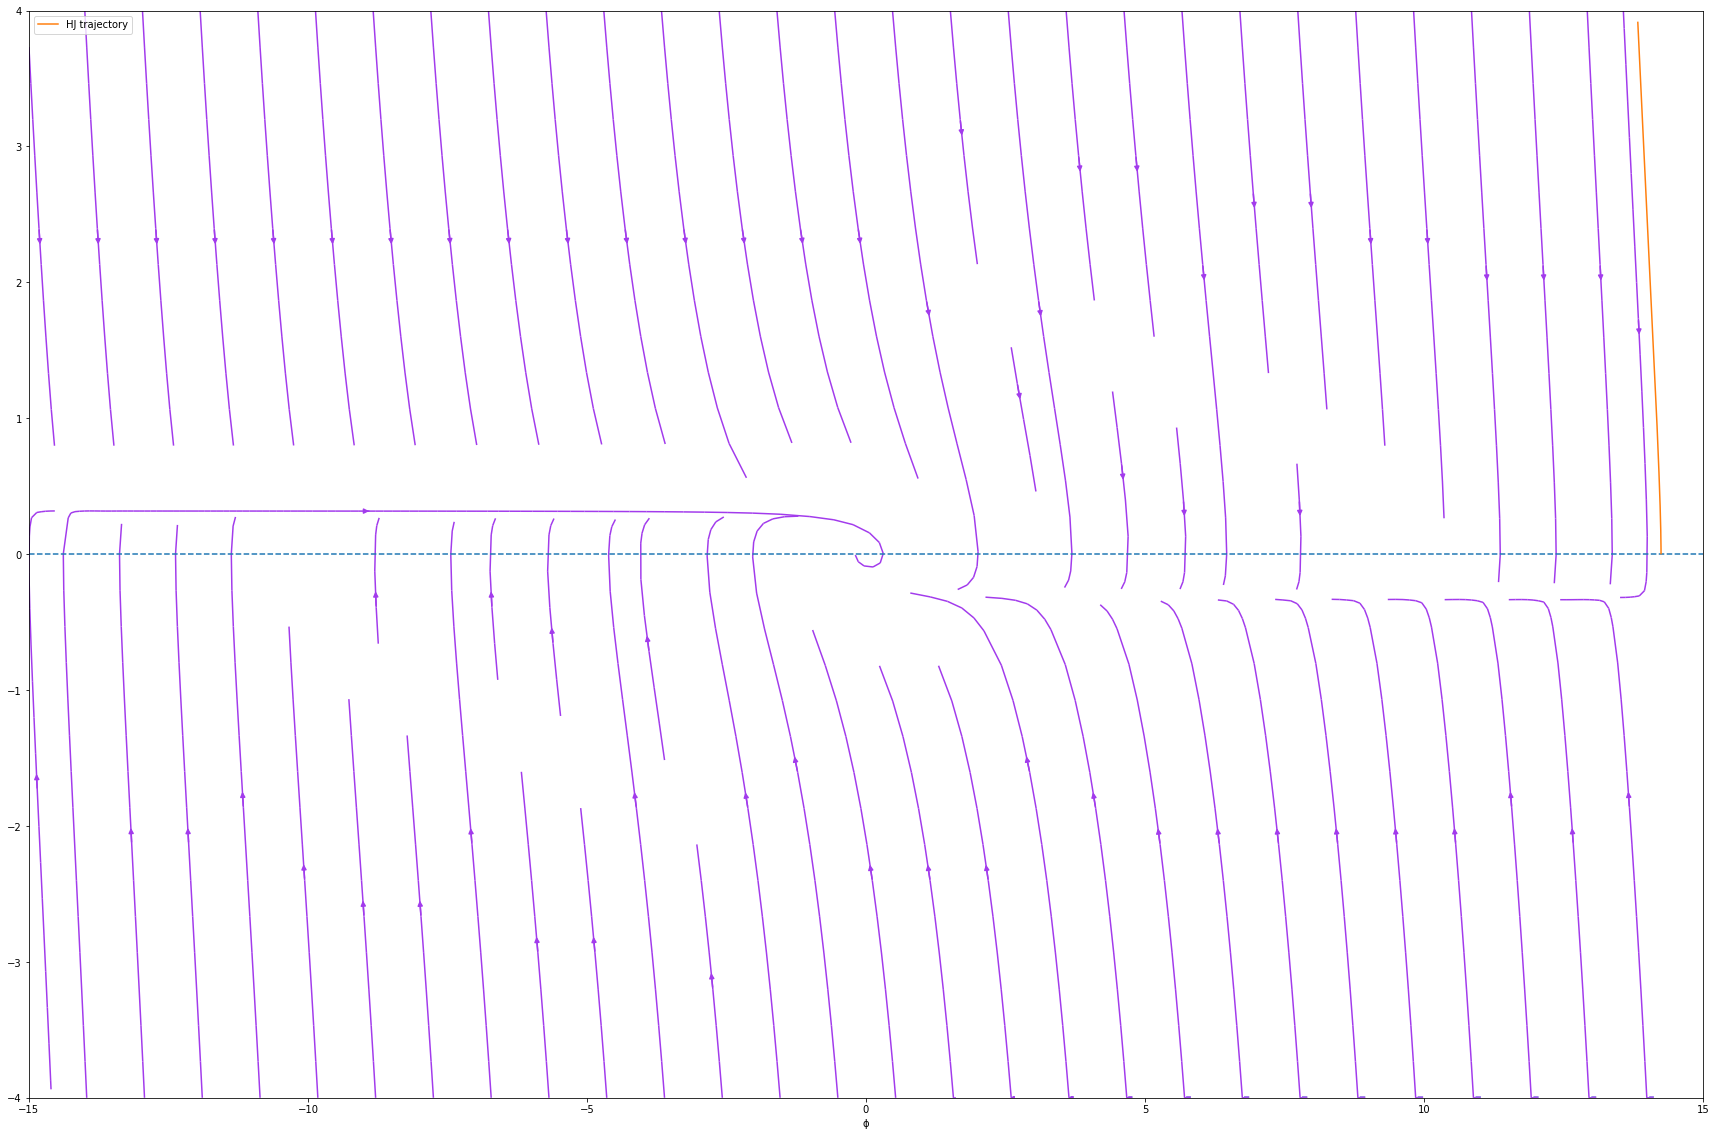

In [50]:
kchoice = 2
V0choice = 0.08

M = 2*V0choice
xbound = 15
ybound = 4
nx, ny = 1024, 1024
x = np.linspace(-1*xbound, xbound, nx)
y = np.linspace(-ybound, ybound, ny)
X, Y = np.meshgrid(x, y)

plane = py.figure(figsize=(30, 20)) 
py.streamplot(X, Y, vect(X, Y, M)[0], vect(X, Y, M)[1], density=1.0, linewidth=None, color='#A23BEC')
py.plot(np.linspace(-xbound, xbound, 101), np.zeros(101), '--')

phi, H, n, epsilon, N = tot_traj_minus(60, V0choice, kchoice, phi_0 = 14, suppress = False, epsilonstop = True)
Vset = [V0choice*ϕ**kchoice for ϕ in phi]
phidot = [(6*((H[i])**2) - 2*(Vset[i]))**0.5 for i in range(len(phi))]
py.plot(phi, phidot, label='HJ trajectory')
#py.plot(phi, epsilon, label='ε')
py.xlabel('ϕ')
py.legend()
print("n =", n, end = '\n')
print("N =", N, end = '\n')
for i, el in enumerate(epsilon):
    if el >1 and i>0:
        print("Full trajectory not available via this method - ε > 1 at n = %s"%i)
        break

Now let's do this for general $V$

In [ ]:
def vect(x, y, m, V = lambda m, x: 0.5*m*(x**2), Vprime = lambda m, x: m*x):
#m = 2*V0
    xdot = y
    ydot = -((3)**0.5)*y*(0.5*(y**2) + V(m,x))**0.5 - Vprime(m,x)
    return xdot, ydot